Importamos primero las librerías que se utilizarán a lo largo del trabajo

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import wittgenstein as lw
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Ahora cargamos el dataset y lo visualizamos

In [27]:
original_data = pd.read_csv('./Pokemon-original.csv')
original_data.head(10)

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
5,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
6,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
7,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
8,6,Mega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
9,6,Mega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


***

#### Corrección de valores nulos

Podemos observar el valor NaN en el type2. Esto se debe a que son Pokémon monotipo, es decir que poseen un único tipo. Reemplazamos ese valor faltante por monotype, que nos permitirá más adelante realizar análisis específicos. Utilizaremos la variable original_data para almacenar el dataset original, sin modificaciones.

Visualizaremos el cambio y después haremos una primera observación de la distribución de tipos. 

In [28]:
clean_data = original_data.copy()
clean_data['type2'].fillna('monotype', inplace=True)
clean_data.head(10)

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
5,4,Charmander,Fire,monotype,309,39,52,43,60,50,65,1,False
6,5,Charmeleon,Fire,monotype,405,58,64,58,80,65,80,1,False
7,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
8,6,Mega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
9,6,Mega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False


***

#### Distribución por tipos y limpieza de errores

Contabilizamos la cantidad de Pokémon por tipo. Para esto realizamos un mergeo de tipos. Como ejemplo: si tenemos 3 Pokémon, 
1 - Tipo 1: Planta | Tipo 2: Agua
2 - Tipo 1: Agua | Tipo 2: monotype
3 - Tipo 1 Agua | Tipo 2: Volador

Debemos obtener lo siguiente:
- Agua: 3
- Planta: 1
- Volador: 1
- monotype: 1

In [29]:
from collections import Counter
# Cuento los tipos de cada columna
type_counts = Counter(clean_data['type1']) + Counter(clean_data['type2'])
sorted_types_counts = sorted(type_counts.items())
# Mostrar los resultados
for tipo, count in sorted_types_counts:
    print(f'Type {tipo} = {count}')

Type Blastoise = 1
Type Bug = 93
Type Dark = 76
Type Dragon = 76
Type Electric = 74
Type Fairy = 67
Type Fighting = 77
Type Fire = 85
Type Flying = 123
Type Ghost = 69
Type Graass = 1
Type Grass = 123
Type Ground = 81
Type Ice = 57
Type Normal = 128
Type Poison = 83
Type Psychic = 123
Type Rock = 76
Type Steel = 75
Type Water = 158
Type monotype = 498


Observamos que aparece un tipo Blastoise y otro Graass. El primero es el nombre de un Pokémon y es error de dataentry; el segundo es error de tipeo. Corregimos al primero como Water y al segundo como Grass

In [31]:
clean_data['type1'] = clean_data['type1'].replace('Blastoise', 'Water')
clean_data['type1'] = clean_data['type1'].replace('Graass', 'Grass')

type_counts = Counter(clean_data['type1']) + Counter(clean_data['type2'])

sorted_type_counts = sorted(type_counts.items())

print("\nFrecuencia de cada tipo:")
for tipo, count in sorted_type_counts:
    print(f'Tipo {tipo} = {count}')


Frecuencia de cada tipo:
Tipo Bug = 93
Tipo Dark = 76
Tipo Dragon = 76
Tipo Electric = 74
Tipo Fairy = 67
Tipo Fighting = 77
Tipo Fire = 85
Tipo Flying = 123
Tipo Ghost = 69
Tipo Grass = 124
Tipo Ground = 81
Tipo Ice = 57
Tipo Normal = 128
Tipo Poison = 83
Tipo Psychic = 123
Tipo Rock = 76
Tipo Steel = 75
Tipo Water = 159
Tipo monotype = 498


***

#### Distribución por tipos por categoría

Primero haremos una visualización de cuántos Pokémon hay legendarios y cuántos no. Luego, visualizaremos la distribución de tipos en las categorías centrales que tienen los Pokémon: Legendarios, Megaevoluciones, Gigantamax y Comunes. Sabemos que las versiones Gigantamax y las Megaevoluciones son de Pokémon comunes, pero hacemos esta diferenciación porque, recordamos, buscamos obtener las características que diferencian un Pokémon Legendario de uno que no lo es.

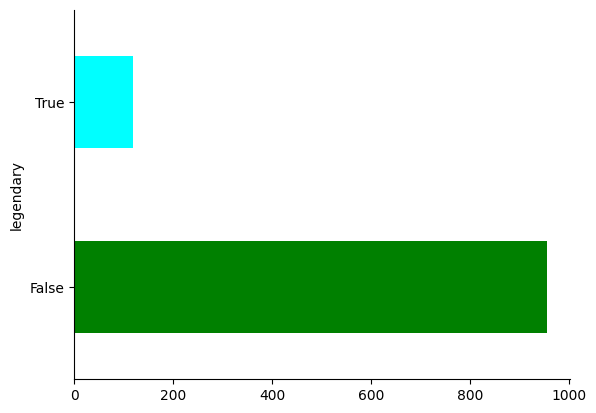

In [32]:
clean_data.groupby('legendary').size().plot(kind='barh', color=['green','cyan'])
plt.gca().spines[['top', 'right',]].set_visible(False)

A continuación observar la distribución de tipos según:
1 - El conjunto del dataset
2 - Legendarios
3 - Pokémon no legendarios Megaevolucionados
4 - Pokémon no legendarios Gigantamax
5 - Pokémon no legendarios quitando las Megaevoluciones y los Gigantamax

In [33]:
#Definimos una variable colors que usaremos en todas las distribuciones de tipo
colors = list(mcolors.TABLEAU_COLORS)[:19]

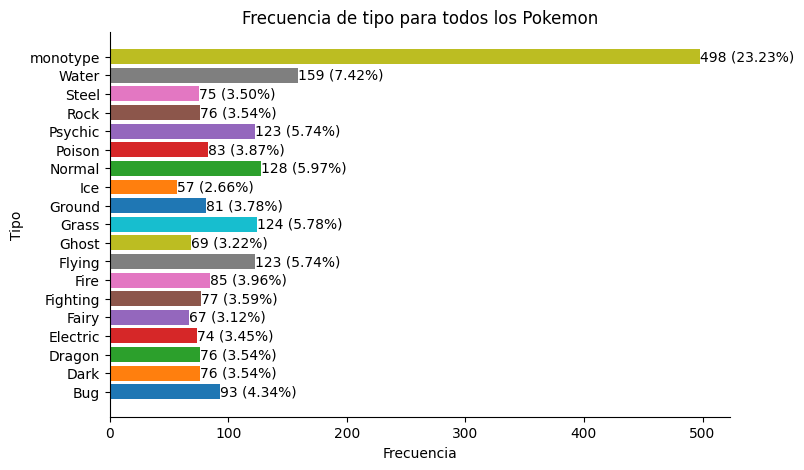

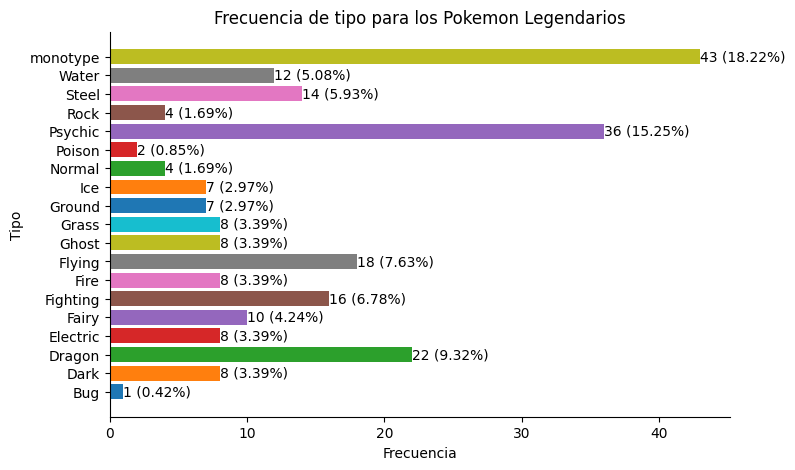

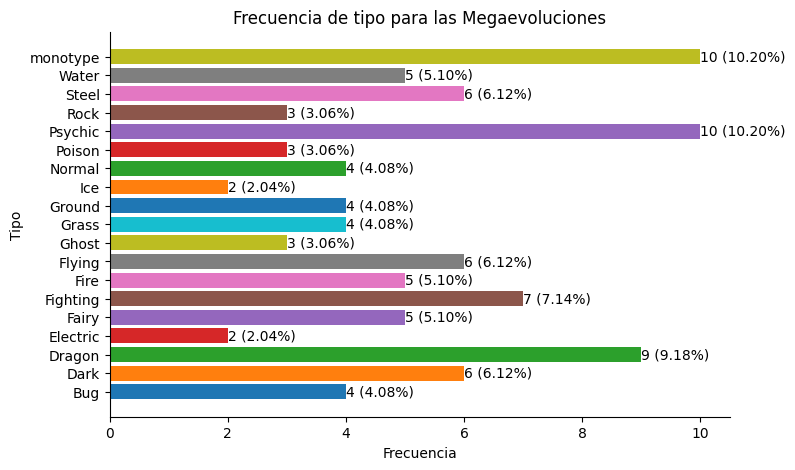

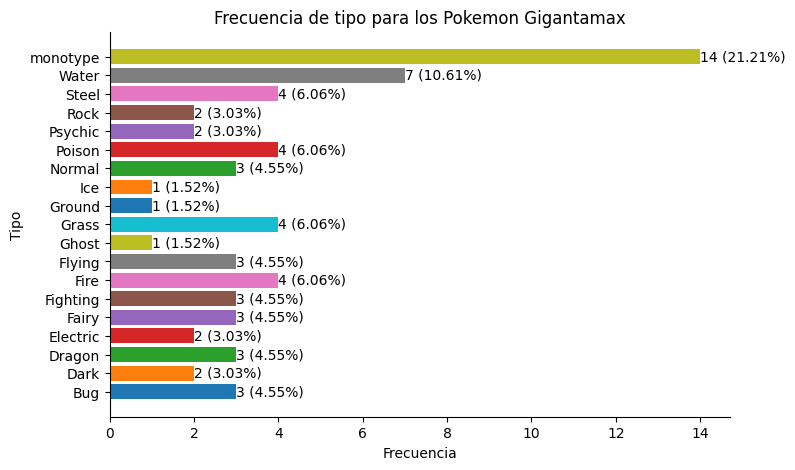

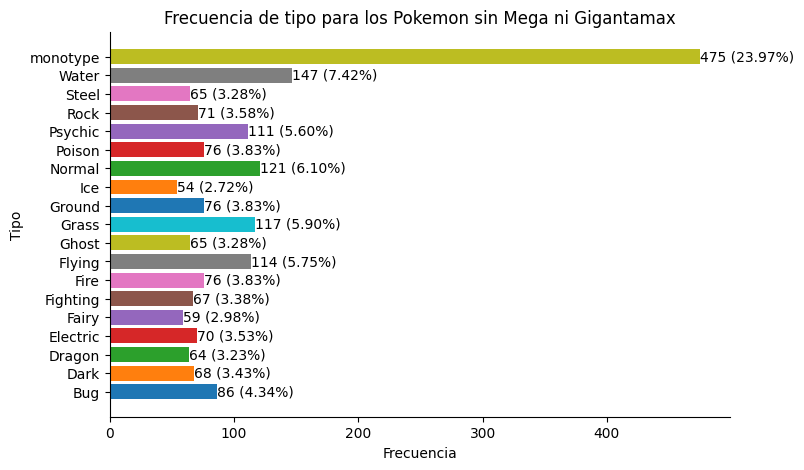

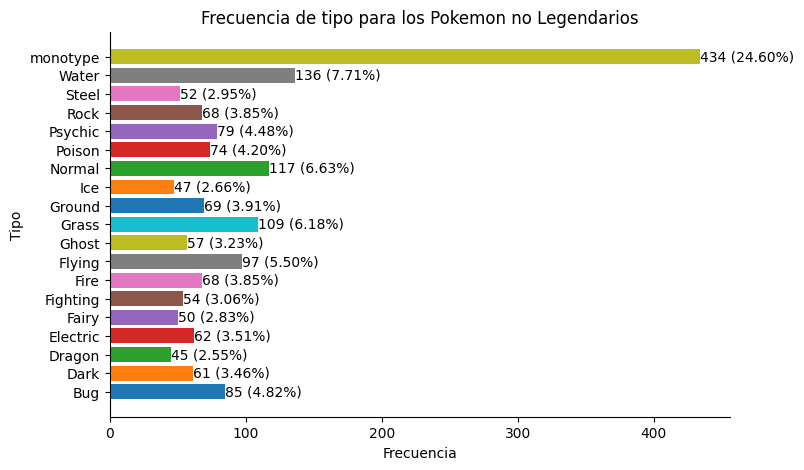

In [34]:
def createBarDiagram(pokemon_group,title):
    sorted_pokemon_group = dict(sorted(pokemon_group.items()))
    total_count = sum(sorted_pokemon_group.values())
    plt.figure(figsize=(8, 5))
    plt.barh(list(sorted_pokemon_group.keys()), list(sorted_pokemon_group.values()),color=colors)
    plt.xlabel('Frecuencia')
    plt.ylabel('Tipo')
    plt.title(title)
    for index, value in enumerate(sorted_pokemon_group.values()):
        percentage = (value / total_count) * 100
        plt.text(value, index, f'{value} ({percentage:.2f}%)', va='center')
    plt.gca().spines[['top', 'right']].set_visible(False)
    
legendary_data = clean_data[clean_data['legendary'] == True ]
legendary_types = Counter(legendary_data['type1']) + Counter(legendary_data['type2'])
mega_data = clean_data[clean_data['name'].str.contains(r'Mega')]
mega_types = Counter(mega_data['type1']) + Counter(mega_data['type2'])
giga_data = clean_data[clean_data['name'].str.contains(r'Gigantamax ')]
giga_types = Counter(giga_data['type1']) + Counter(giga_data['type2'])
pokemon_without_mega_giga_data = clean_data[~clean_data['name'].str.contains(r'Gigantamax |Mega ')]
pokemon_without_mega_giga_types = Counter(pokemon_without_mega_giga_data['type1']) + Counter(pokemon_without_mega_giga_data['type2'])
common_pokemon_data = pokemon_without_mega_giga_data[~pokemon_without_mega_giga_data['legendary']==True]
common_pokemon_types = Counter(common_pokemon_data['type1']) + Counter(common_pokemon_data['type2'])

createBarDiagram(type_counts,'Frecuencia de tipo para todos los Pokemon')
createBarDiagram(legendary_types,'Frecuencia de tipo para los Pokemon Legendarios')
createBarDiagram(mega_types,'Frecuencia de tipo para las Megaevoluciones')
createBarDiagram(giga_types,'Frecuencia de tipo para los Pokemon Gigantamax')
createBarDiagram(pokemon_without_mega_giga_types,'Frecuencia de tipo para los Pokemon sin Mega ni Gigantamax')
createBarDiagram(common_pokemon_types,'Frecuencia de tipo para los Pokemon no Legendarios')

En la siguiente tabla podemos ver la distribución de tipos según los Pokémon sean comunes, legendarios, megaevoluciones o gigantamax:

In [35]:
types_data = {
    "Tipo": sorted(set(common_pokemon_types) | set(legendary_types) | set(mega_types) | set(giga_types)),
    "Comun": [common_pokemon_types.get(tipo, 0) for tipo in sorted(set(common_pokemon_types) | set(legendary_types) | set(mega_types) | set(giga_types))],
    "Legendario": [legendary_types.get(tipo, 0) for tipo in sorted(set(common_pokemon_types) | set(legendary_types) | set(mega_types) | set(giga_types))],
    "Mega": [mega_types.get(tipo, 0) for tipo in sorted(set(common_pokemon_types) | set(legendary_types) | set(mega_types) | set(giga_types))],
    "Gigantamax": [giga_types.get(tipo, 0) for tipo in sorted(set(common_pokemon_types) | set(legendary_types) | set(mega_types) | set(giga_types))]
}

df = pd.DataFrame(types_data)

total_common = sum(df["Comun"])
total_legendary = sum(df["Legendario"])
total_mega = sum(df["Mega"])
total_giga = sum(df["Gigantamax"])

df["% Comun"] = df["Comun"] / total_common * 100
df["% Legendario"] = df["Legendario"] / total_legendary * 100
df["% Mega"] = df["Mega"] / total_mega * 100
df["% Gigantamax"] = df["Gigantamax"] / total_giga * 100

df = df[["Tipo", "Comun", "% Comun", "Legendario", "% Legendario","Mega", "% Mega", "Gigantamax", "% Gigantamax"]]

# Agregar la última fila con los totales
total_row = pd.DataFrame([{
    "Tipo": '',
    "Comun": total_common,
    "% Comun": 100,
    "Legendario": total_legendary,
    "% Legendario": 100,
    "Mega": total_mega,
    "% Mega": 100,
    "Gigantamax": total_giga,
    "% Gigantamax": 100
}])

df = pd.concat([df, total_row], ignore_index=True)
print(df.to_markdown(index=False))

| Tipo     |   Comun |   % Comun |   Legendario |   % Legendario |   Mega |    % Mega |   Gigantamax |   % Gigantamax |
|:---------|--------:|----------:|-------------:|---------------:|-------:|----------:|-------------:|---------------:|
| Bug      |      85 |   4.81859 |            1 |       0.423729 |      4 |   4.08163 |            3 |        4.54545 |
| Dark     |      61 |   3.45805 |            8 |       3.38983  |      6 |   6.12245 |            2 |        3.0303  |
| Dragon   |      45 |   2.55102 |           22 |       9.32203  |      9 |   9.18367 |            3 |        4.54545 |
| Electric |      62 |   3.51474 |            8 |       3.38983  |      2 |   2.04082 |            2 |        3.0303  |
| Fairy    |      50 |   2.83447 |           10 |       4.23729  |      5 |   5.10204 |            3 |        4.54545 |
| Fighting |      54 |   3.06122 |           16 |       6.77966  |      7 |   7.14286 |            3 |        4.54545 |
| Fire     |      68 |   3.85488 |      

***

### Stats por tipo

Realizamos el promedio del total por tipo y para cada subgrupo. Esto nos permite ver que que varios Pokémon en su versión megaevolución superan los stats de Pokémon legendarios; es es la razón por la cual los quitamos del dataset para no confundir el procesamiento posterior. Por otro lado, si nos fijamos en el promedio de los legendarios observamos que para el tipo Veneno está muy por encima de los valores generales, lo cual muestra un posible outlier. Cuando vamos al dataset encontramos que se encuentra el Pokémon Eternatus en su versión Eternamax (equivalente a Gigantamax). Se desprende de esto que en verdad solo había 1 Pokémon legendario de tipo Veneno, tal como sucede con el tipo bicho. 

In [36]:
# Calcular los promedios de estadísticas por tipo
def calculate_type_averages(pokemon_df, type1_col='type1', type2_col='type2', total_col='total'):
    # Crear dos DataFrames separados para type1 y type2
    type1_df = pokemon_df[[type1_col, total_col]].rename(columns={type1_col: 'type'})
    type2_df = pokemon_df[[type2_col, total_col]].rename(columns={type2_col: 'type'})

    # Concatenar los dos DataFrames
    combined_df = pd.concat([type1_df, type2_df])

    # Calcular los totales y los conteos para cada tipo
    type_totals = combined_df.groupby('type')[total_col].sum()
    type_counts = combined_df.groupby('type').size()

    # Calcular los promedios
    type_averages = (type_totals / type_counts).to_dict()

    return type_averages

averages_df = pd.DataFrame({
    'Common': calculate_type_averages(common_pokemon_data),
    'Mega': calculate_type_averages(mega_data),
    'Giga': calculate_type_averages(giga_data),
    'Legendary': calculate_type_averages(legendary_data)
})
print (averages_df.round(2))

          Common    Mega    Giga  Legendary
Bug       370.96  573.75  475.00     600.00
Dark      423.92  590.83  530.00     605.00
Dragon    453.53  671.56  501.67     688.32
Electric  426.31  592.50  411.00     593.75
Fairy     393.96  586.60  505.00     625.00
Fighting  435.61  620.43  535.00     589.69
Fire      431.22  611.60  524.75     636.25
Flying    414.31  651.33  474.67     616.67
Ghost     422.23  545.00  500.00     647.50
Grass     403.59  593.50  506.25     581.25
Ground    409.62  626.25  510.00     633.43
Ice       432.47  587.00  535.00     640.00
Normal    389.68  573.50  385.00     647.50
Poison    400.11  573.33  500.25     907.50
Psychic   415.42  658.60  507.50     617.33
Rock      432.29  671.67  497.50     615.00
Steel     446.23  607.50  532.50     610.00
Water     409.03  611.00  519.29     600.83
monotype  391.20  602.00  473.14     587.09


Procedemos a quitar a Eternamax. El promedio del stat total en tipo Veneno para los Legendarios nos da 690. Eternamax es el Pokémon más poderoso de ese tipo. Está, igualmente, dentro de una proporción cercana a la de otros legendarios.

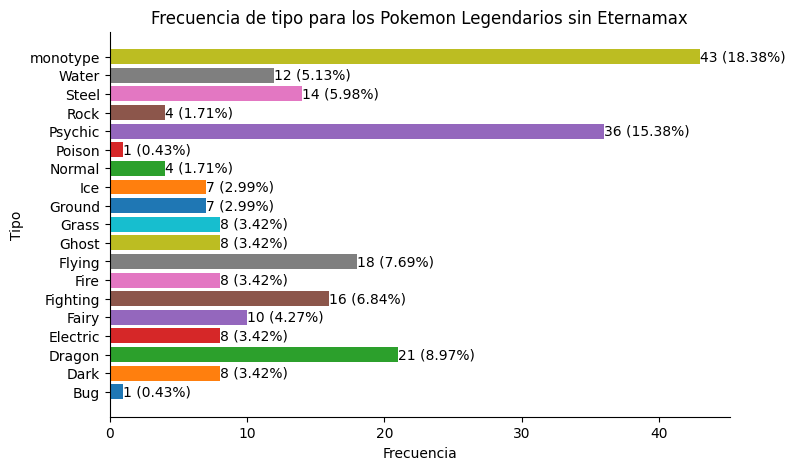

In [37]:
legendary_data = clean_data[clean_data['legendary'] == True ]
legendary_data= legendary_data[~legendary_data['name'].str.contains(r'Eternamax ')]
legendary_types = Counter(legendary_data['type1']) + Counter(legendary_data['type2'])
createBarDiagram(legendary_types,'Frecuencia de tipo para los Pokemon Legendarios sin Eternamax')

***

### Problema pseudolegendarios

Como señalamos en la descripción del dataset, el atributo ‘Total’ es la sumatoria del conjunto de los stats. Es un atributo redundante que simplifica, pero puede generar confusiones a la hora de avanzar en análisis más detallados y de obtener conclusiones más precisas. Lo usaremos en esta sección para precisar a grandes rasgos las diferencias de tipos y de Pokémon legendarios y no legendarios, pero más adelante omitiremos esa columna para trabajar con cada stat en particular y su relación con el objeto de estudio en sí. En los siguientes gráficos podemos ver este atributo tanto para los Pokémonlegendarios como para los que no lo son. Ya hemos quitado, como hemos dicho, las megaevoluciones y las versiones gigantamax.

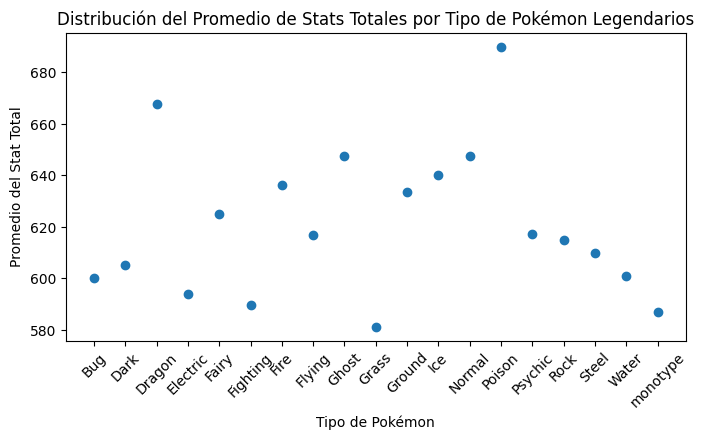

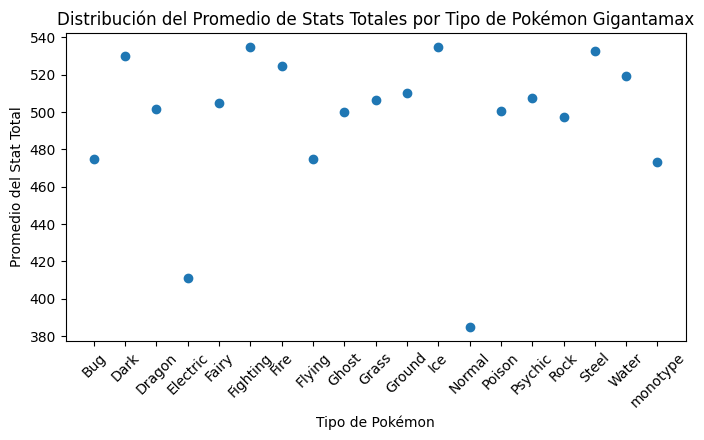

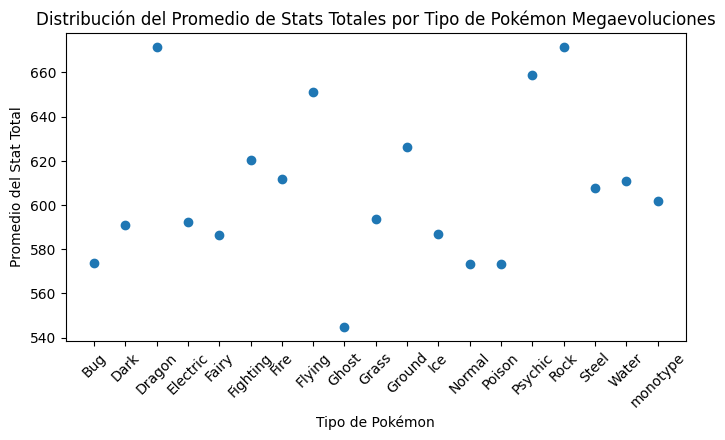

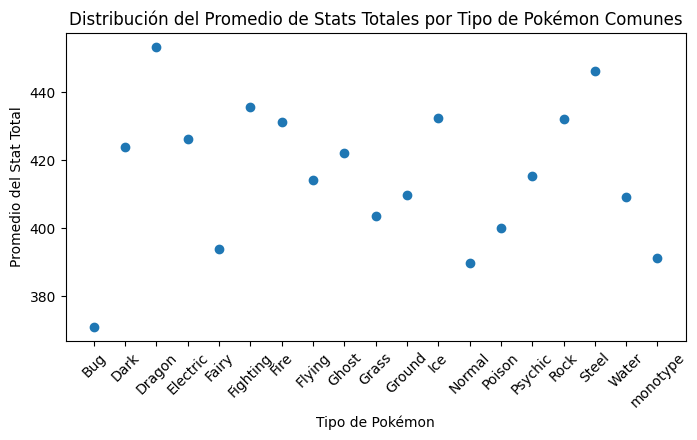

In [38]:
def calculate_type_means(pokemon_df, type1_col='type1', type2_col='type2', total_col='total'):
    # Crear dos DataFrames separados para type1 y type2
    type1_df = pokemon_df[[type1_col, total_col]].rename(columns={type1_col: 'type'})
    type2_df = pokemon_df[[type2_col, total_col]].rename(columns={type2_col: 'type'})

    # Concatenar los dos DataFrames
    combined_df = pd.concat([type1_df, type2_df])

    # Calcular los promedios
    type_means = combined_df.groupby('type')[total_col].mean()

    return type_means

def plotter_create(grouped,title):
  # Crear el scatter plot
  plt.figure(figsize=(8,4))
  # Usar los valores agrupados para el scatter plot
  plt.scatter(grouped.index, grouped.values)

  # Etiquetas y título del gráfico
  plt.xlabel('Tipo de Pokémon')
  plt.ylabel('Promedio del Stat Total')
  plt.title('Distribución del Promedio de Stats Totales por Tipo de Pokémon '+ title)

  plt.xticks(rotation=45)

  plt.show()

grouped_legendary = calculate_type_means(legendary_data)
grouped_giga = calculate_type_means(giga_data)
grouped_mega = calculate_type_means(mega_data)
grouped_common = calculate_type_means(common_pokemon_data)

plotter_create(grouped_legendary,'Legendarios')
plotter_create(grouped_giga,'Gigantamax')
plotter_create(grouped_mega,'Megaevoluciones')
plotter_create(grouped_common,'Comunes')

Hacemos una visualización de los stats totales por nombre y nos encontramos con el siguiente gráfico que muestra una pequeña cantidad de pokémon muy por encima de la generalidad. En el fandom6 se los llama ‘pseudolegendarios’ porque sus stats superan incluso a muchos legendarios. Son Pokémon comunes, no pueden ser quitados del dataset, con lo cual tenemos que proceder a realizar otro tipo de tratamientos para evitar el error a la hora de las predicciones.

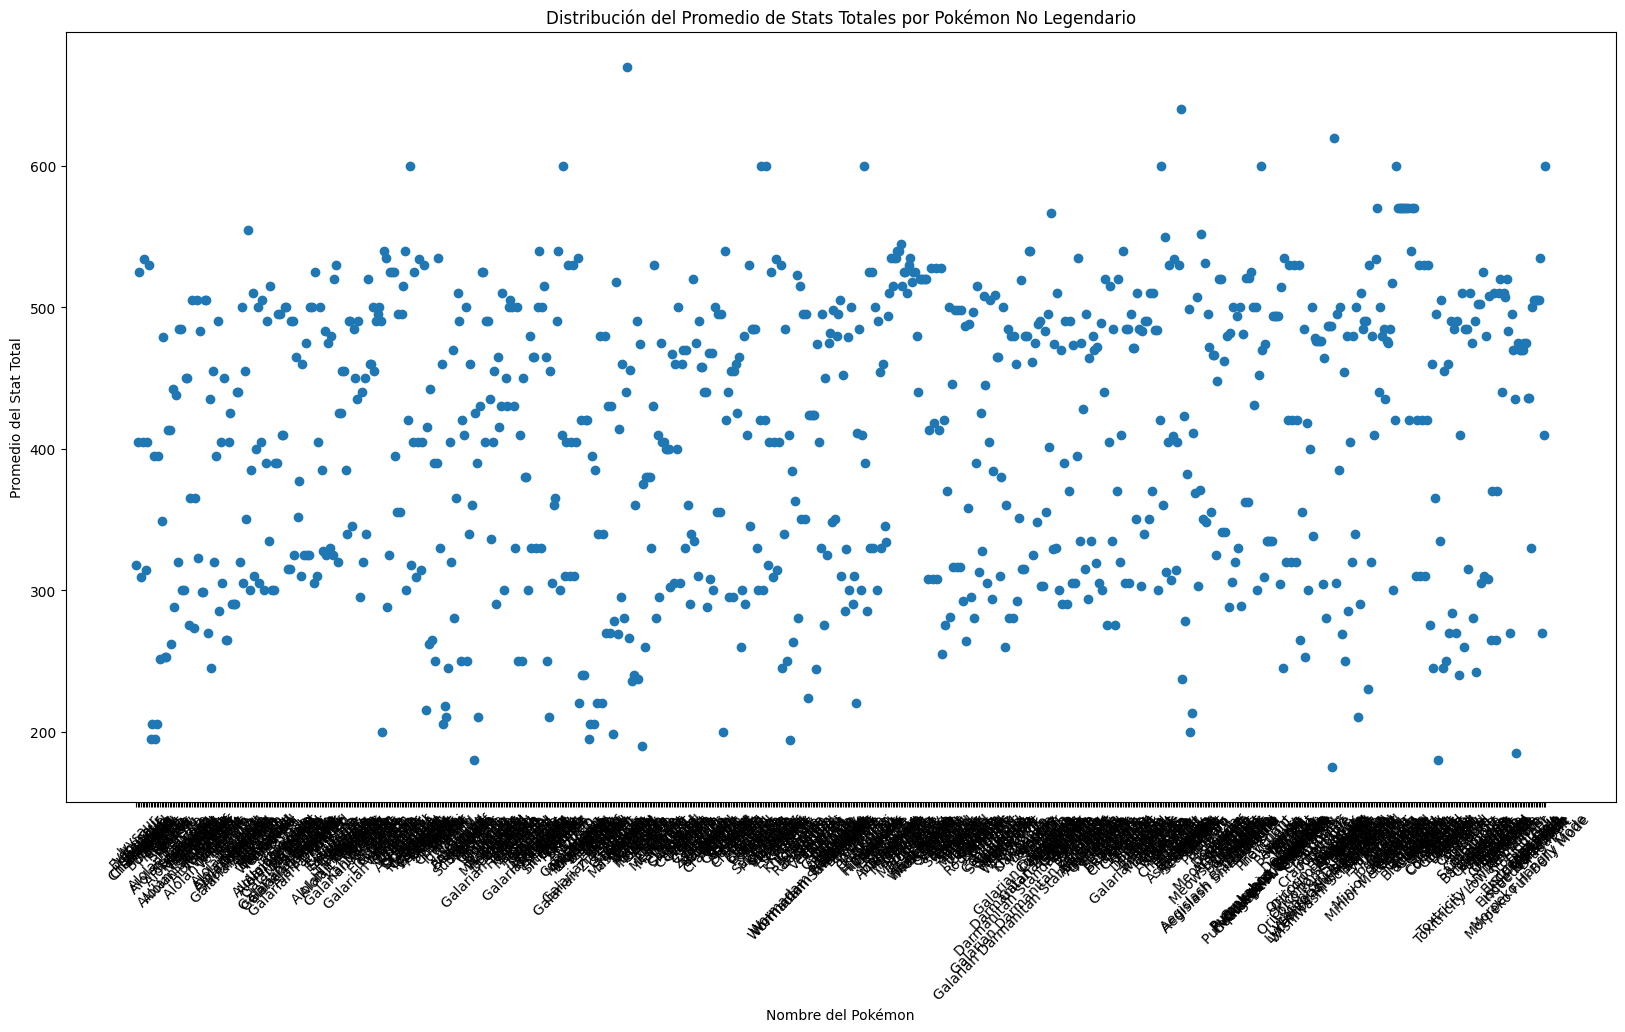

In [39]:
plt.figure(figsize=(20, 10))
plt.scatter(common_pokemon_data['name'],common_pokemon_data['total'])
plt.xlabel('Nombre del Pokémon')
plt.ylabel('Promedio del Stat Total')
plt.title('Distribución del Promedio de Stats Totales por Pokémon No Legendario')
plt.xticks(rotation=45)
plt.show()

Filtramos total en 600 para obtener los pseudolegendarios. Descubrimos que existen dos Pokémon en el dataset que no están correctos. Por un lado el Ash-Greninja que es una licencia particular del anime. Por el otro Wishiwashi que solamente tiene esos stats cuando está en una forma determinada, pero al perder vida esto se reduce considerablemente. Los quitaremos.

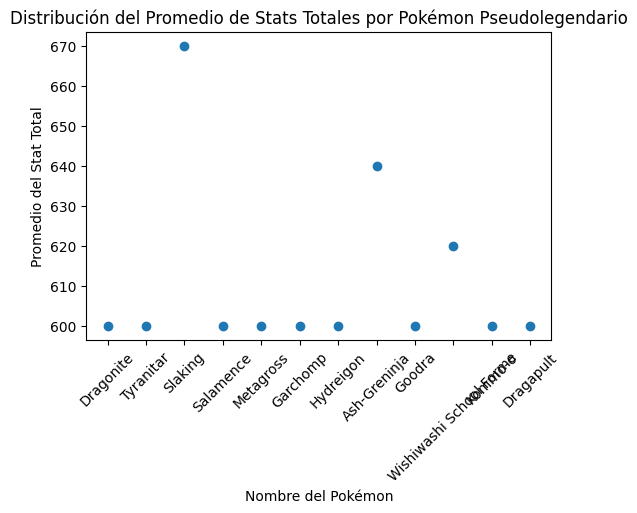

In [40]:
pseudolegendarios_data = common_pokemon_data[common_pokemon_data['total'] >= 600]
plt.figure(figsize=(6, 4))
plt.scatter(pseudolegendarios_data['name'],pseudolegendarios_data['total'])
plt.xlabel('Nombre del Pokémon')
plt.ylabel('Promedio del Stat Total')
plt.title('Distribución del Promedio de Stats Totales por Pokémon Pseudolegendario')
plt.xticks(rotation=45)
plt.show()

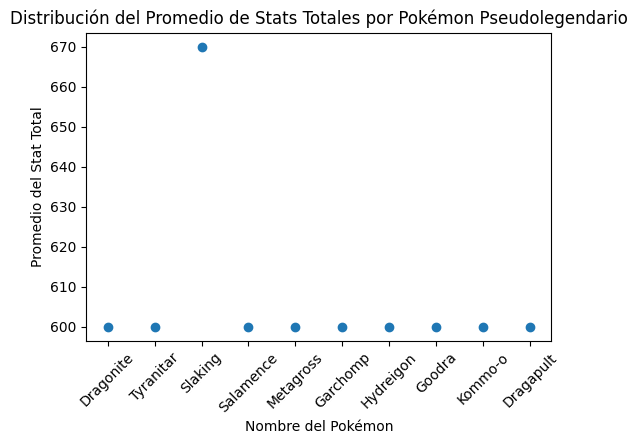

In [41]:
common_pokemon_data = common_pokemon_data[~common_pokemon_data['name'].str.contains(r'Wishiwashi ')]
common_pokemon_data = common_pokemon_data[~common_pokemon_data['name'].str.contains(r'Ash-Greninja')]
pseudolegendarios_data = common_pokemon_data[common_pokemon_data['total'] >= 600]
plt.figure(figsize=(6, 4))
plt.scatter(pseudolegendarios_data['name'],pseudolegendarios_data['total'])
plt.xlabel('Nombre del Pokémon')
plt.ylabel('Promedio del Stat Total')
plt.title('Distribución del Promedio de Stats Totales por Pokémon Pseudolegendario')
plt.xticks(rotation=45)
plt.show()

En la siguiente tabla dejamos el nombre, los stats y los tipos de estos pseudolegendarios para mejor visibilidad del lector. Son en total 10 Pokémon.

Varias cosas son de aquí destacables. En primer lugar hay un ‘pseudolegendario’ por generación a excepción de la 3era donde hubo 3, pero no volvió a repetirse; por otro lado, a excepción de Tyranitar de la 2da generación todos los ‘pseudolegendarios’ de cada una es de tipo Dragón. Si volvemos a la tabla que mostraba promedio de stats por tipo, veremos que ‘Dragón’ era el de más alto promedio, ahora podemos entender porqué. Quizás también explique la predilección por legendarios de este tipo (el 10%, siendo el segundo tipo con más legendarios después de los tipo Psíquico)

In [42]:
selected_columns = ['name', 'total', 'type1', 'type2', 'generation']
pseudo_legendary_info = pseudolegendarios_data[selected_columns]

# Renombrar las columnas para el cuadro final
pseudo_legendary_info.columns = ['Nombre', 'Stats total', 'Tipo 1', 'Tipo 2', 'Generación']

print(pseudo_legendary_info)

         Nombre  Stats total  Tipo 1    Tipo 2  Generación
202   Dragonite          600  Dragon    Flying           1
310   Tyranitar          600    Rock      Dark           2
358     Slaking          670  Normal  monotype           3
453   Salamence          600  Dragon    Flying           3
457   Metagross          600   Steel   Psychic           3
538    Garchomp          600  Dragon    Ground           4
747   Hydreigon          600    Dark    Dragon           5
828      Goodra          600  Dragon  monotype           6
923     Kommo-o          600  Dragon  Fighting           7
1051  Dragapult          600  Dragon     Ghost           8


***

### Procesamiento y modelo de clasificación

Estamos en condiciones de realizar un árbol de decisión para clasificar, ahora sí, qué Pokémon es Legendario y cuál no. 

#### Árbol de decisión usando atributo 'total'

Generamos un árbol de Decisión utilizando, todavía, la columna total. Vemos un accuracy del 98,99%, mostrando la absoluta relevancia de este con respecto a la predicción de si será o no legendario un Pokémon dado. Quitaremos este atributo, de ahora en más, para los próximos análisis.

Accuracy: 98.99%
|--- total <= 575.00
|   |--- total <= 547.50
|   |   |--- class: False
|   |--- total >  547.50
|   |   |--- class: False
|--- total >  575.00
|   |--- class: True



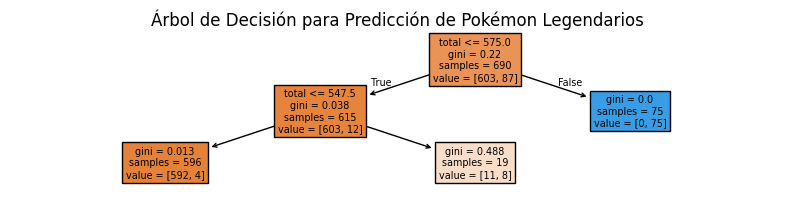

In [43]:
pseudolegendarios_nombres = set(pseudolegendarios_data['name'])
# Filtrar los Pokémon comunes excluyendo los pseudo-legendarios
common_pokemon_without_pseudolegen = common_pokemon_data[~common_pokemon_data['name'].isin(pseudolegendarios_nombres)]
final_data = pd.concat([common_pokemon_without_pseudolegen, legendary_data], ignore_index=True)
final_data = pd.get_dummies(final_data, columns=['type1'])
final_data = pd.get_dummies(final_data, columns=['type2'])

# Seleccionar características y etiquetas
features = final_data.drop(columns=['legendary','name','generation','number'])
labels = final_data['legendary']  # Etiquetas

# Dividir los datos en conjuntos de entrenamiento y prueba
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
clf = DecisionTreeClassifier(random_state=42,max_depth=2)

# Entrenar el modelo
clf.fit(features_train, labels_train)

# Hacer predicciones en el conjunto de prueba
labels_pred = clf.predict(features_test)

# Calcular la precisión
accuracy = accuracy_score(labels_test, labels_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualizar el árbol de decisión
plt.figure(figsize=(10, 2))
plot_tree(clf, filled=True, feature_names=features.columns)
plt.title('Árbol de Decisión para Predicción de Pokémon Legendarios')
tree_text = export_text(clf, feature_names=features.columns.tolist())
print(tree_text)

In [44]:
# Obtener predicciones en el conjunto de prueba
labels_pred = clf.predict(features_test)

# Calcular matriz de confusión
cm = confusion_matrix(labels_test, labels_pred)
labels_pred = clf.predict(features_test)

# Obtener el reporte de clasificación
report = classification_report(labels_test, labels_pred, target_names=['Not Legendary', 'Legendary'])

print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
               precision    recall  f1-score   support

Not Legendary       0.99      1.00      0.99       266
    Legendary       1.00      0.90      0.95        30

     accuracy                           0.99       296
    macro avg       0.99      0.95      0.97       296
 weighted avg       0.99      0.99      0.99       296



En este árbol, ahora sin 'total', vemos una reducción de la precisión de más del 99% a algo más del 93%. Es interesante que cuando dejamos el atributo 'hp' este lo toma de raíz, sin embargo la precisión se acerca al 91,89%, pero al quitarlo esta sube al resultado que exponemos. Reducimos la profundidad a 4, en vez de 5, y obtenemos así una mejora que no es menor dado que, como vemos en el cuadro posterior al árbol, el accuracy de la clase Legendary = True es del 86%. 

Al parecer no es la vida un elemento tan central para la predicción que buscamos hacer. 

Este margen de error, igualmente, es aceptable dado que ahora estamos utilizando los atributos reales de cada Pokémon y no la sumatoria de los mismos. Veremos ahora con reglas cómo se traduce.

Accuracy: 93.24%


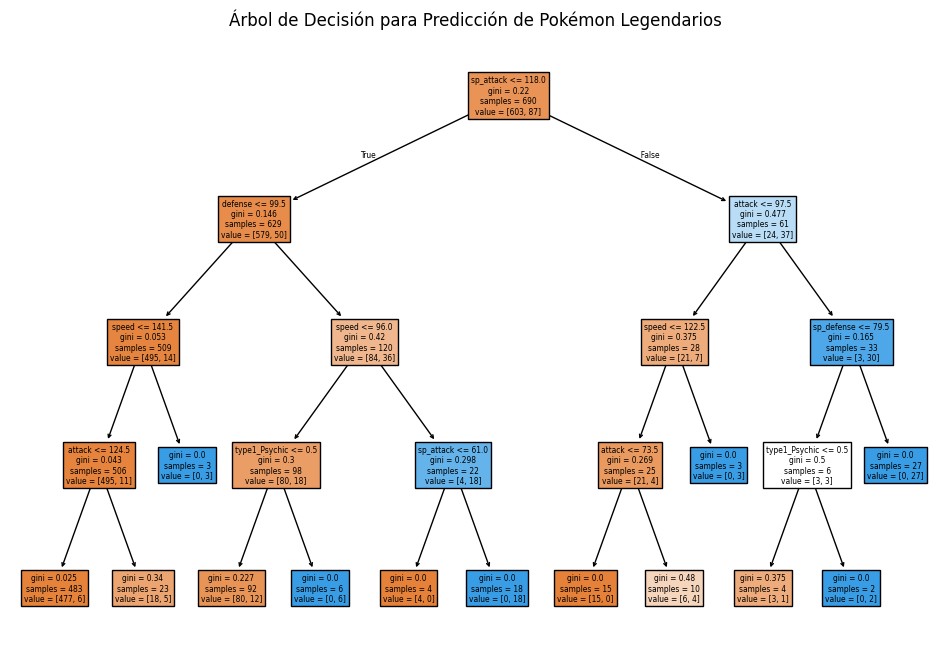

Cross-validated accuracy: 93.19% (+/- 3.25)
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       266
        True       0.86      0.40      0.55        30

    accuracy                           0.93       296
   macro avg       0.90      0.70      0.75       296
weighted avg       0.93      0.93      0.92       296



In [45]:
features = final_data.drop(columns=['legendary', 'name', 'generation', 'number', 'total', 'hp'])
labels = final_data['legendary']

# Dividir los datos en conjuntos de entrenamiento y prueba
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Crear el modelo de árbol de decisión
clf = DecisionTreeClassifier(random_state=42, max_depth=4)

# Entrenar el modelo
clf.fit(features_train, labels_train)

# Hacer predicciones en el conjunto de prueba
labels_pred = clf.predict(features_test)

# Calcular la precisión
accuracy = accuracy_score(labels_test, labels_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Visualizar el árbol de decisión
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=features.columns)
plt.title('Árbol de Decisión para Predicción de Pokémon Legendarios')
plt.show()


# Validación cruzada para evaluar el rendimiento del modelo
scores = cross_val_score(clf, features_train, labels_train, cv=5, scoring='accuracy')
print(f"Cross-validated accuracy: {scores.mean() * 100:.2f}% (+/- {scores.std() * 200:.2f})")

# Reporte de clasificación
print(classification_report(labels_test, labels_pred))


***

#### Reglas de clasificación

Al igual que con el árbol de clasificación, las reglas cuando usamos 'total' tienen una precisión más alta, arriba del 96% y reflejan claramente la relación casi directa entre este atributo y si el Pokémon es o no Legendario.

In [46]:
features = final_data.drop(columns=['legendary', 'name', 'generation', 'number'])
labels = final_data['legendary']  # Etiquetas

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ripper_model = lw.RIPPER()
scores = cross_val_score(ripper_model, features, labels, scoring='accuracy', cv=cv)
print(f'Accuracy: {scores.mean() * 100:.2f}% (+/- {scores.std() * 100:.2f}%)')

ripper_model.fit(features, labels)

for rule in ripper_model.ruleset_.rules:
    print(f"Rule: {rule}")

Accuracy: 96.04% (+/- 1.65%)
Rule: [total=>580.0]
Rule: [total=520.0-580.0^hp=90.0-100.0^type2_monotype=False^type1_Fire=False]
Rule: [total=520.0-580.0^defense=>113.5^attack=66.0-75.0]
Rule: [total=520.0-580.0^type1_Psychic=True]
Rule: [total=520.0-580.0^speed=>105.5^type1_Electric=True]
Rule: [sp_defense=75.0-81.5^sp_attack=>114.0]


Sin la columna 'total' vemos una reducción de la precisión que llega alrededor del 90%, marcando ya un margen de error mucho más alto que hasta el momento.

In [47]:
features = final_data.drop(columns=['legendary', 'name', 'generation', 'number','total'])
labels = final_data['legendary']  # Etiquetas

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ripper_model = lw.RIPPER()
scores = cross_val_score(ripper_model, features, labels, scoring='accuracy', cv=cv)
print(f'Accuracy: {scores.mean() * 100:.2f}% (+/- {scores.std() * 100:.2f}%)')

ripper_model.fit(features, labels)

# Mostrar las reglas
for rule in ripper_model.ruleset_.rules:
    print(f"Rule: {rule}")


Accuracy: 91.78% (+/- 1.56%)
Rule: [sp_attack=>114.0^speed=>105.5^hp=90.0-100.0]
Rule: [sp_attack=>114.0^attack=102.0-120.0]
Rule: [attack=>120.0^sp_attack=>114.0]
Rule: [hp=90.0-100.0^speed=95.0-105.5]
Rule: [sp_defense=>105.5^defense=>113.5^hp=90.0-100.0]
Rule: [sp_defense=>105.5^speed=85.0-95.0^type1_Electric=False]
Rule: [speed=>105.5^defense=85.0-95.0^type1_Normal=False]
Rule: [sp_defense=>105.5^defense=>113.5^hp=79.0-90.0]
Rule: [attack=>120.0^sp_attack=75.0-85.0]
Rule: [hp=>100.0^speed=95.0-105.5]
Rule: [type1_Psychic=True^defense=>113.5]
Rule: [speed=>105.5^hp=79.0-90.0^type1_Electric=True]


***

#### Clasificación por generación

Hacemos una primera distribución por generación y observamos que existen Pokémon con generación 0; revisamos y son dos Pokémon que en realidad pertenecen a la 7ma generación. Corregimos y ahora ya tenemos la cantidad de Pokémon por cada generación. 

Primero contabilizo la cantidad de Pokémon por generación. Luego de ello, procedemos a observar la distribución de tipos, como hicimos más arriba, por cada generación. Esto nos permitirá avanzar en las conclusiones. 

In [48]:
generation_data =pokemon_without_mega_giga_data
generation_data = generation_data[~generation_data['name'].str.contains(r'Ash-Greninja')]
generation_data = generation_data[~generation_data['name'].str.contains(r'Eternamax ')]
generation_data['generation'] = generation_data['generation'].replace(0, 7)
generations = generation_data.groupby('generation')
gen_dict = {gen: data for gen, data in generations}

gen1 = gen_dict[1]
gen2 = gen_dict[2]
gen3 = gen_dict[3]
gen4 = gen_dict[4]
gen5 = gen_dict[5]
gen6 = gen_dict[6]
gen7 = gen_dict[7]
gen8 = gen_dict[8]

for gen in range(1, 9):
   print(f'Generación {gen}: {len(gen_dict[gen])} Pokémon')



Generación 1: 151 Pokémon
Generación 2: 100 Pokémon
Generación 3: 140 Pokémon
Generación 4: 116 Pokémon
Generación 5: 164 Pokémon
Generación 6: 83 Pokémon
Generación 7: 116 Pokémon
Generación 8: 119 Pokémon


Visualizamos la distribución de tipos para cada generación.

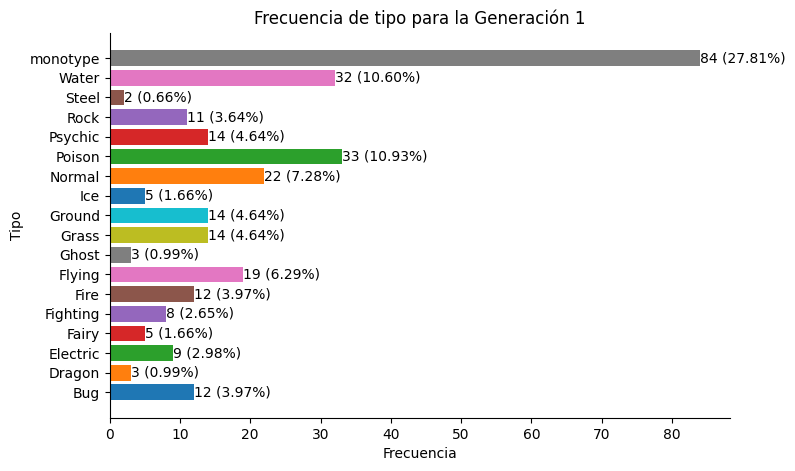

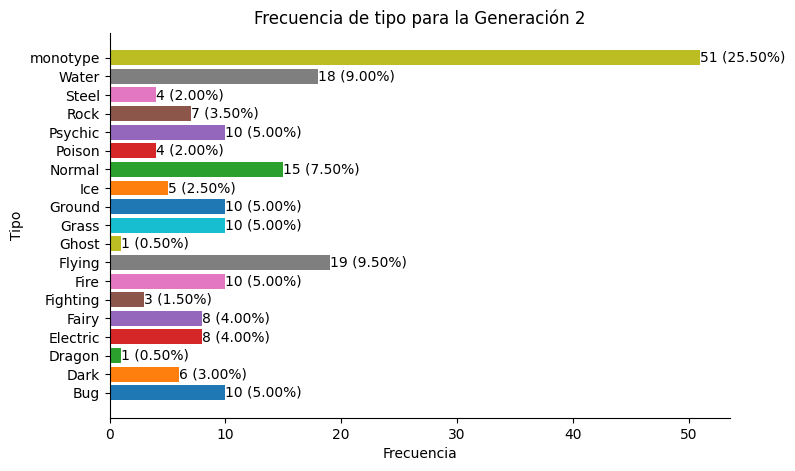

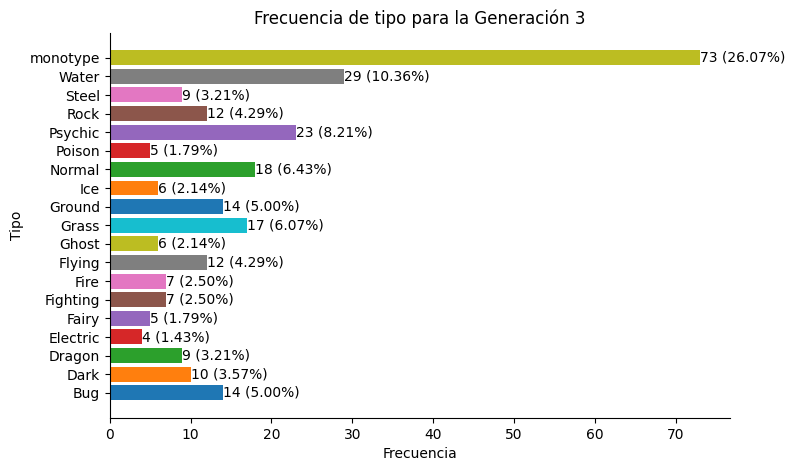

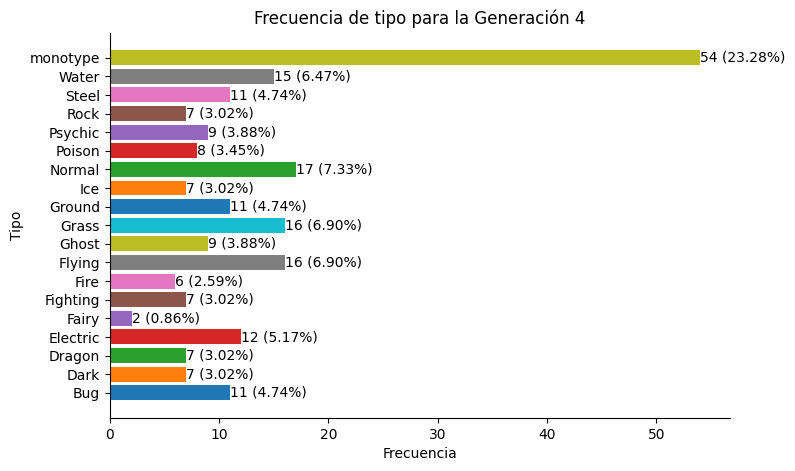

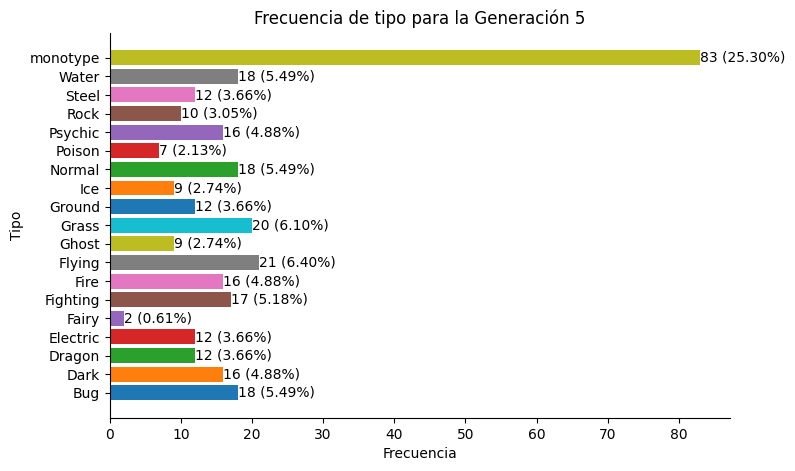

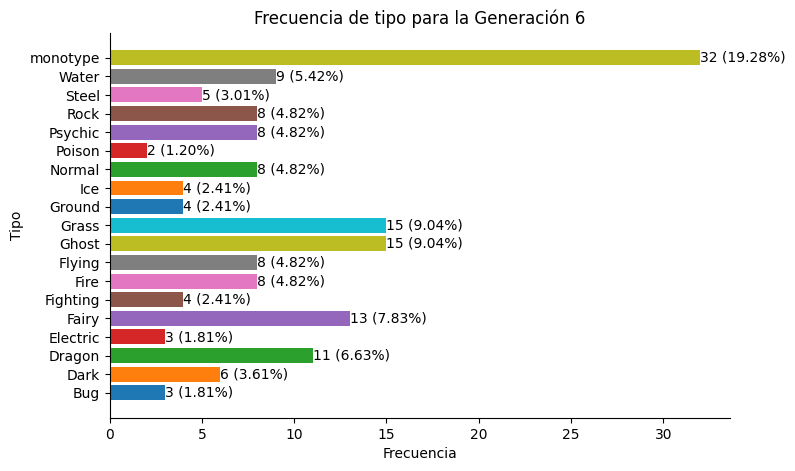

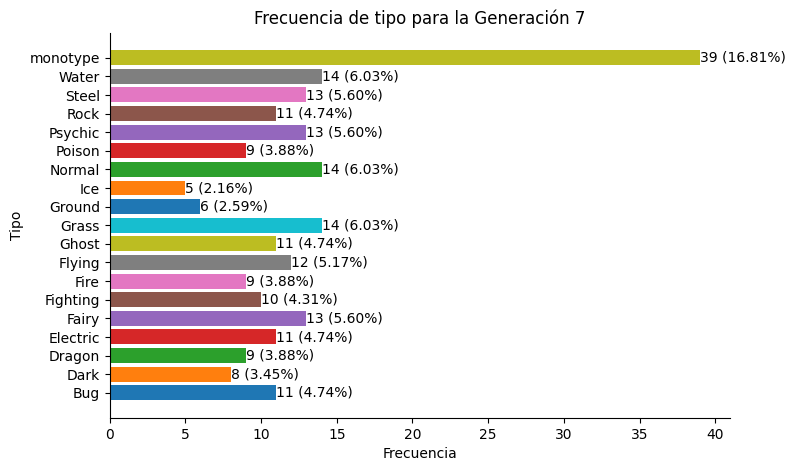

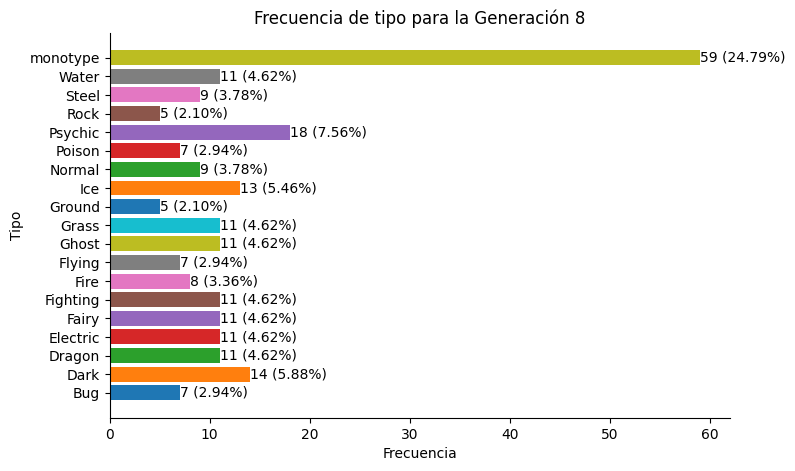

In [49]:
for gen in range (1,9):
    gen_data = generation_data[generation_data['generation'] == gen]
    genetarion_type = Counter(gen_data ['type1']) + Counter(gen_data['type2'])
    createBarDiagram(genetarion_type,f'Frecuencia de tipo para la Generación {gen}')

Podemos ver la preponderancia de algunos tipos, por ejemplo la mitad de los Pokémon de 1° Generación se concentran en 7 tipos. Si vamos avanzando en las generaciones, esto tiende a una distribución más equitativa. Es posible que se deba a que algunos tipos fueron agregándose en generaciones posteriores. Por ejemplo, el tipo Hada se agregó en 6° generación, lo cual si vemos la tabla anterior nos parece coherente con el hecho de que sea el tercer tipo predominante, con casi un 8% del total de Pokémon, cuando en generaciones anteriores a veces no llegaba ni al 1%. En todas las generaciones aparecen los tipo Agua y los tipo Normal entre los preponderantes, lo cual se condice con la primera tabla de inicios de este informe. El cambio en la forma de la distribución se debe, principalmente, a la reducción de los tipo Veneno en un 80% (del 1 de cada 10 a 1 de cada 30), los Agua (1 de cada 10 a 1 de cada 20) y los Volador (1 de cada 15 a 1 de cada 20 aproximadamente); estas reducciones fueron contrapuestas con el surgimiento de nuevos tipos como Siniestro, Hada, Acero o Dragón.

Además de esto, podemos notar como generación a generación se incorpora una cantidad similar de Pokémon, un poco más de 200, con lo cual es viable utilizar este número como ejemplo para pronosticar futuras distribuciones.

¿Qué sucede si enfocamos la lupa solo en los legendarios, tipo, por generación?

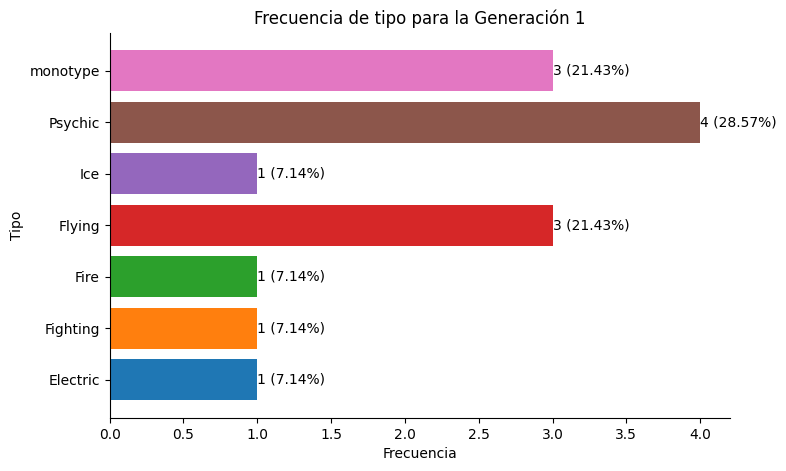

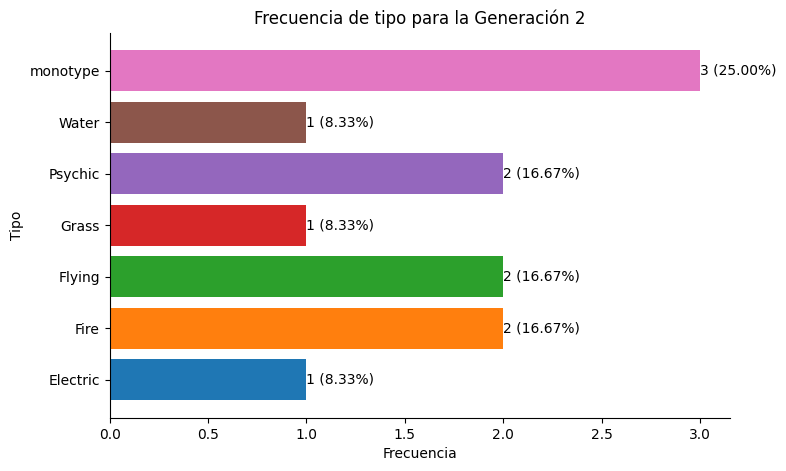

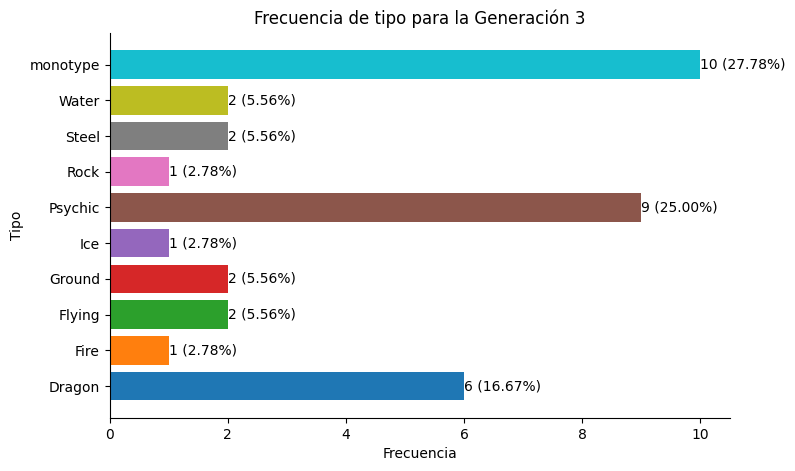

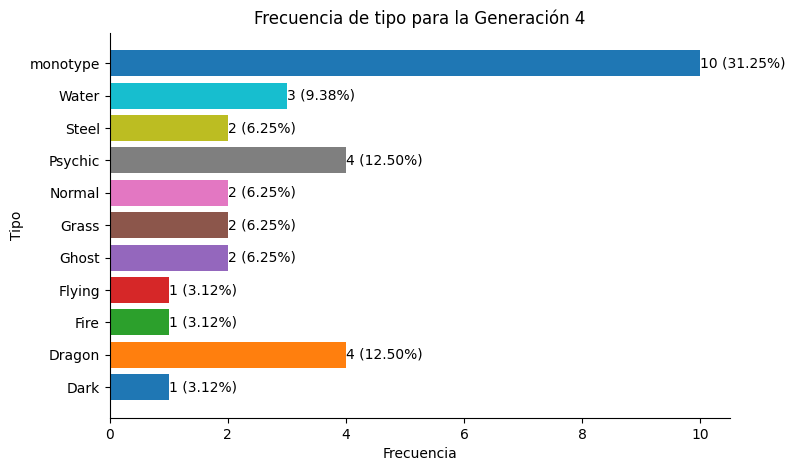

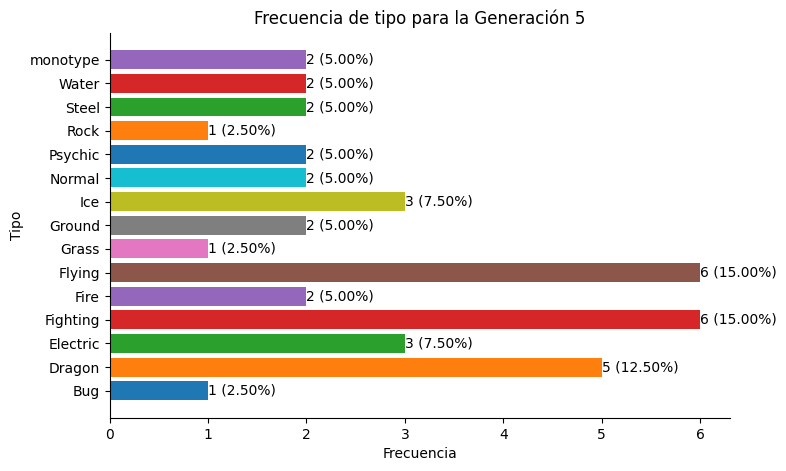

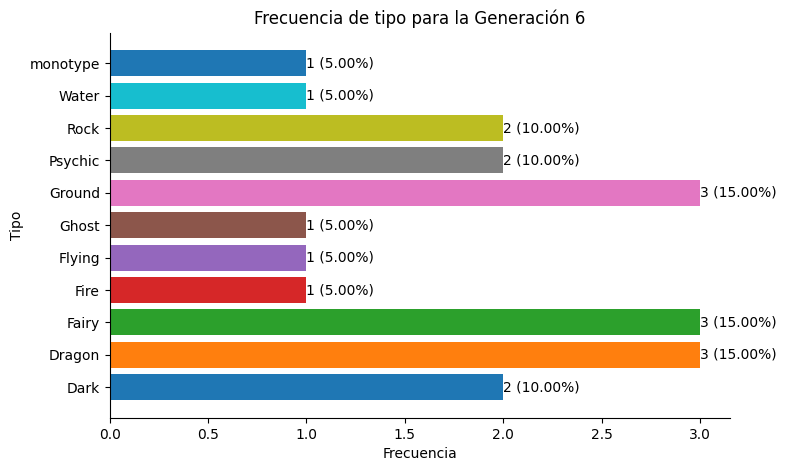

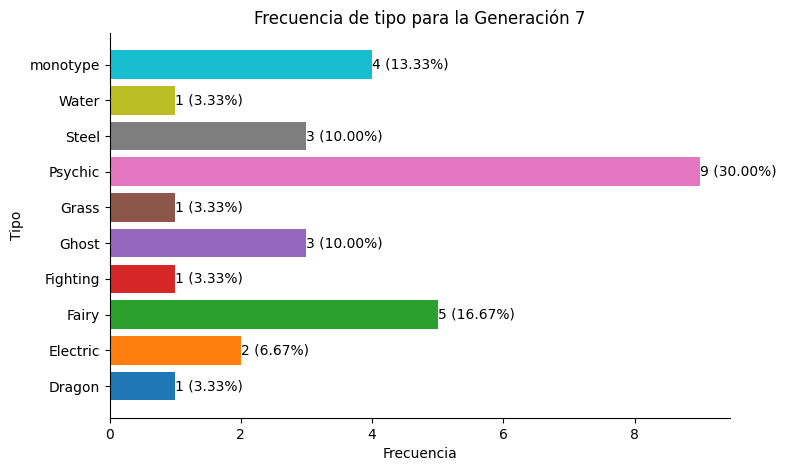

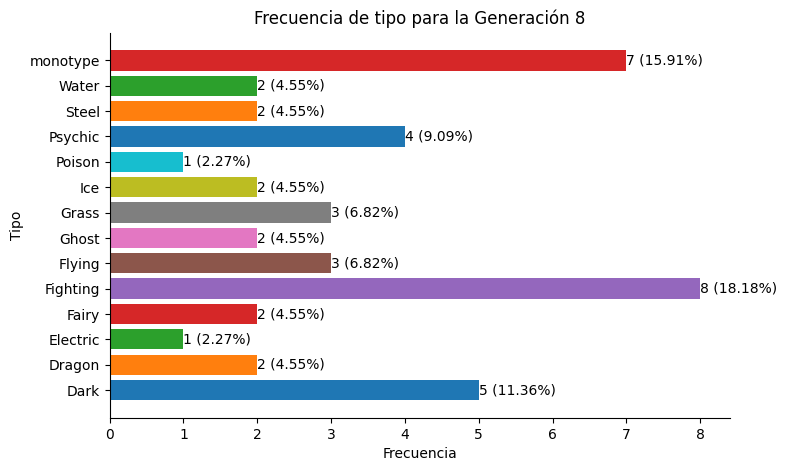

In [50]:
for gen in range (1,9):
    legendary_gen_data = legendary_data[legendary_data['generation'] == gen]
    legendary_genetarion_type = Counter(legendary_gen_data ['type1']) + Counter(legendary_gen_data['type2'])
    createBarDiagram(legendary_genetarion_type,f'Frecuencia de tipo para la Generación {gen}')

Lo primero que podemos afirmar es que en todas las generaciones hay un Pokémon de tipo Psíquico, con lo cual en próximas entregas sería probable que esto también se repitiese, dado que, a su vez, dijimos que el 18%, es decir 1 de cada 5 Pokémon legendarios, era de este tipo.

***

###  Prónostico y conclusiones

Sabemos que el proceso de limpieza del dataset podría haber sido más riguroso, existen algunos Pokémon que tienen formas diferentes y que aparecen en este conjunto de datos y no han sido quitados. Sin embargo, creemos que hemos alcanzado un suficiente grado de análisis que nos permite constatar la existencia de cierta lógica en la distribución de Pokémon a lo largo de las diferentes generaciones. Las siguientes son algunas conclusiones que esperamos poder corroborar a partir de próximas entregas de la franquicia. Como ya se dijo, existe una 9na generación ya vigente8. La hemos utilizado como prueba de las conclusiones a las que creemos es posible arribar tras este extenso estudio. En el Anexo puede encontrarse la distribución de tipos de esta última generación, también diferenciamos los legendarios que aquí se introducen y la distribución de tipos de los mismos.

Con todo lo ante dicho, en la tabla siguiente exponemos los pronósticos que alcanzamos, la situación real de la 9na generación y si el pronóstico se corroboró o no. En aquellos casos donde esto no sucedió, es donde futuros estudios deberán puntualizar. 

Sabemos que es posible obtener más información, pero consideramos que es un primer paso a la hora de responder cómo serán las próximas entregas de Pokémon. Intentando resolver la pregunta que todo consumidor de la franquicia se hace “¿Quién es ese Pokémon?”.

| Pronóstico                                                                                  | Situación 9na Generación                                  | Resultado                          |
|---------------------------------------------------------------------------------------------|-----------------------------------------------------------|-----------------------------------|
| Un Pokémon ‘pseudolegendario’ que muy probablemente sea de tipo Dragón                      | Baxcalibur, tipo Dragón y Hielo                            | OK                                |
| Habrá algo más de 100 nuevos Pokémon                                                        | 120 nuevos Pokémon                                         | OK                                |
| Al menos el 20% será de Tipo único                                                          | 17,8% Tipo único                                           | Bastante aproximado               |
| Veneno y Bicho serán las distribuciones más escasas de Pokémon. Luego vendrá Dragón y Hielo | Bicho y Hielo son las más escasas, 2,92% cada una. Dragón y Veneno no. Veneno impulsado por los legendarios (4 son Veneno, si no fuera así, entonces sí se cumpliría) | A Medias                          |
| Al menos el 5% será Agua, Planta, Normal y Volador                                          | Agua, Planta, Normal sí. Volador no. Es la generación con menor cantidad de este tipo (2,5%) | Bastante aproximado               |
| Menos del 10% serán legendarios                                                             | 10% Legendarios                                            | OK                                |
| Al menos 1 Pokémon legendario será Psíquico                                                 | 1 Psíquico                                                 | OK                                |
| Muy posiblemente no haya Legendario tipo Bicho                                                              | 0 tipo Bicho                                               | OK                                |